In [1]:
import pandas
from pandas import DataFrame, get_dummies
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import model_selection

In [2]:
df_hist = pandas.read_excel("soda_sales_historical_data.xlsx")

In [3]:
df_hist[:5]

,Product,Sales,Cost Per Unit,Easter Included,Super Bowl Included,Christmas Included,Other Holiday,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 Weeks,Sales M-5 weeks
0,11 Down,51.9,1.6625,No,No,Yes,No,80.69,69.19,17.0,22.4,13.5,14.5,28.0
1,Alpine Stream,55.8,2.2725,No,No,Yes,No,80.69,69.19,2.4,2.2,2.0,1.4,0.5
2,Bright,3385.6,1.3475,No,No,Yes,No,80.69,69.19,301.8,188.8,101.4,81.6,213.8
3,Crisp Clear,63.5,1.6600,No,No,Yes,No,80.69,69.19,73.8,69.4,72.8,75.4,57.4
4,Popsi Kola,181.1,1.8725,No,No,Yes,No,80.69,69.19,23.1,22.6,22.1,19.9,23.2


In [4]:
df_hist.shape

(596, 14)

In [5]:
categorical_columns = ['Product','Easter Included','Super Bowl Included', 'Christmas Included',
                       'Other Holiday']
df_hist = get_dummies(df_hist, prefix={k:"dmy_%s"%k for k in categorical_columns},
                      columns = list(categorical_columns))
df_hist[:5]

,Sales,Cost Per Unit,4 Wk Avg Temp,4 Wk Avg Humidity,Sales M-1 weeks,Sales M-2 weeks,Sales M-3 weeks,Sales M-4 Weeks,Sales M-5 weeks,dmy_Product_11 Down,...,dmy_Product_Koala Kola,dmy_Product_Mr. Popper,dmy_Product_Popsi Kola,dmy_Easter Included_No,dmy_Easter Included_Yes,dmy_Super Bowl Included_No,dmy_Super Bowl Included_Yes,dmy_Christmas Included_No,dmy_Christmas Included_Yes,dmy_Other Holiday_No
0,51.9,1.6625,80.69,69.19,17.0,22.4,13.5,14.5,28.0,1,...,0,0,0,1,0,1,0,0,1,1
1,55.8,2.2725,80.69,69.19,2.4,2.2,2.0,1.4,0.5,0,...,0,0,0,1,0,1,0,0,1,1
2,3385.6,1.3475,80.69,69.19,301.8,188.8,101.4,81.6,213.8,0,...,0,0,0,1,0,1,0,0,1,1
3,63.5,1.6600,80.69,69.19,73.8,69.4,72.8,75.4,57.4,0,...,0,0,0,1,0,1,0,0,1,1
4,181.1,1.8725,80.69,69.19,23.1,22.6,22.1,19.9,23.2,0,...,0,0,1,1,0,1,0,0,1,1


In [6]:
experiments = {"Algorithm":["Ordinary Least Squares", "Regression Tree", "Big Random Forest", "Random Forest", 
                            "Bagging"], 
               "Objects" : [lambda : LinearRegression(), lambda : DecisionTreeRegressor(), 
                            lambda : RandomForestRegressor(n_estimators=100), 
                            lambda : RandomForestRegressor(), 
                            lambda : BaggingRegressor()], 
               "Predictions":[[] for _ in range(5)]}
actuals = []

In [7]:
from sklearn.model_selection import train_test_split
[_.shape for _ in  train_test_split(df_hist.drop("Sales", axis=1), df_hist["Sales"], test_size=0.25)]

[(447, 24), (149, 24), (447,), (149,)]

In [8]:
for _ in range (4):
    train_X, test_X, train_y, test_y = train_test_split(df_hist.drop("Sales", axis=1), 
                                                        df_hist["Sales"], test_size=0.25)
    for i, obj_factory in enumerate(experiments["Objects"]):
        obj = obj_factory()
        obj.fit(y=train_y,X=train_X)
        experiments["Predictions"][i] += list(obj.predict(test_X))
    actuals += list(test_y)
actuals = pandas.Series(actuals)
experiments["Predictions"] = list(map(pandas.Series, experiments["Predictions"]))

In [9]:
len(actuals), map(len, experiments["Predictions"])

(596, [596, 596, 596, 596, 596])

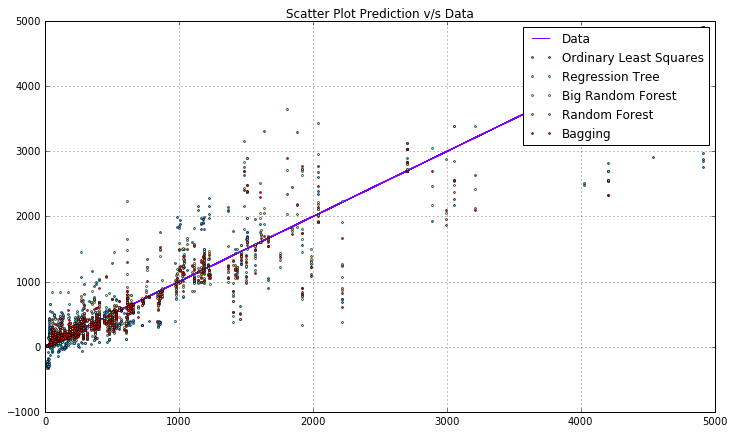

In [10]:
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
color=iter(cm.rainbow(np.linspace(0,1,len(experiments)+3)))
plt.figure(figsize=(12,7),dpi=300)
plt.plot(actuals,actuals,c=next(color),markersize=2,label='Data')
for _, row in DataFrame(experiments).iterrows():
    plt.plot(actuals, row["Predictions"],'o',c=next(color),markersize=2,label=row['Algorithm'])
plt.title('Scatter Plot Prediction v/s Data')
plt.grid(True)
plt.legend()
plt.show()

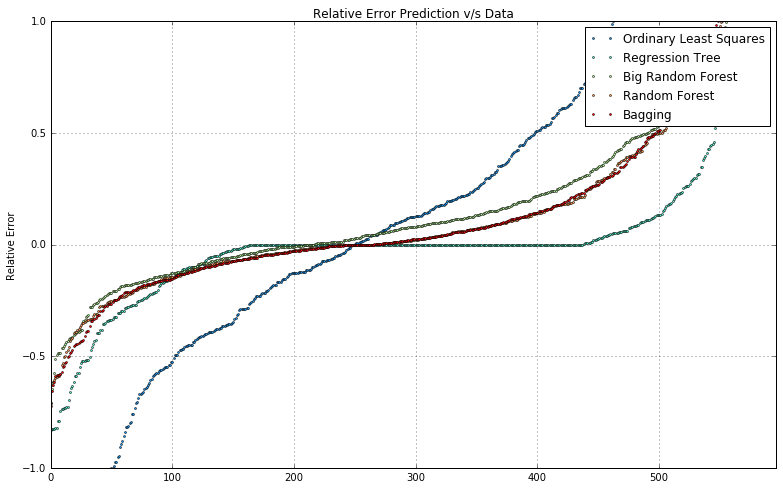

In [11]:
color=iter(cm.rainbow(np.linspace(0,1,len(experiments)+3)))
next(color)
plt.figure(figsize=(13,8),dpi=300)
for index, row in DataFrame(experiments).iterrows():
    relative_error = (row["Predictions"] - actuals) / (1 + abs(actuals))
    plt.plot(np.sort(relative_error),'o',c=next(color),markersize=2,label=row['Algorithm'])
plt.title('Relative Error Prediction v/s Data')
plt.ylabel('Relative Error')
plt.grid(True)
plt.legend()
plt.axis([0,len(actuals),-1,1])
plt.show()

In [12]:
def boxplot(algorithm):
    prediction = experiments["Predictions"][experiments["Algorithm"].index(algorithm)]
    plt.title(algorithm)
    plt.boxplot( (prediction - actuals) / (1 + abs(actuals))  )
    plt.show()

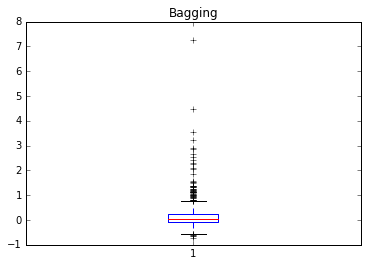

In [13]:
boxplot("Bagging")

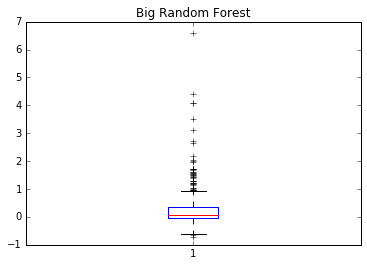

In [14]:
boxplot("Big Random Forest")

In [15]:
experiments["Results"] = []
for o in experiments["Objects"]:
    experiments["Results"].append(
        model_selection.cross_val_score(o(), y=df_hist['Sales'], 
                                        X=df_hist.drop("Sales", axis=1),
                                        cv=5).mean())

In [16]:
DataFrame(experiments).drop(["Objects", "Predictions"], axis=1).set_index("Algorithm")

,Results
Algorithm,
Ordinary Least Squares,0.536984
Regression Tree,0.668860
Big Random Forest,0.835463
Random Forest,0.758291
Bagging,0.757363
